---
title: "SDE/DDPM Connection Tutorial"
author: "Andreas Makris"
date: 2024-12-16
categories: [diffusion, tutorial]
description: "A tutorial to illustrate the connection between DDPM and SDE Diffusion with a toy example."
---


![](sde_ddpm_2.png)

As we know there are two formulations of diffusion models. In this tutorial we show their relationship with a toy example. Diffusion models start from samples from a simple distribution (usually $\mathcal{N}(0,1)$) and iteratively transform them to generate samples from a target distribution (in our example $\mathcal{N}(5,2^2)$). To do so we often need to train a neural network using samples from the target distribution.

We start with the Markov Chain formulation of the diffusion models, also known as **DDPMs**. The forward process (data to noise) is:

$$\boldsymbol{x}_t = \sqrt{1 - \beta_t} \, \boldsymbol{x}_{t-1} + \sqrt{\beta_t} \, \boldsymbol{z}_{t-1}, \quad \boldsymbol{z}_{t-1} \sim \mathcal{N}(0, I), \quad t=1, \ldots, N$$

which can be done in a single step:

$$\boldsymbol{x}_t = \sqrt{\bar{\alpha_t}} \, \boldsymbol{x}_{0} + \sqrt{1-\bar{\alpha}_t} \, \boldsymbol{z}_{t-1}, \quad \boldsymbol{z}_{t-1} \sim \mathcal{N}(0, I), \quad t=1, \ldots, N$$

The reverse Markov Chain uses a neural network that (often) estimates the noise that needs to be removed:

$$\boldsymbol{x}_t=\frac{1}{\sqrt{1-\beta_t}}\left(\boldsymbol{x}_{t+1}-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\hat{\epsilon}(\boldsymbol{x}_{t+1},t+1)\right)+ \sqrt{\beta_t} \, \boldsymbol{z}_{t-1}$$

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

class SimpleNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, num_layers=10, time_embedding_dim=128):
        super(SimpleNet, self).__init__()
        self.time_embedding = nn.Sequential(
            nn.Linear(1, time_embedding_dim),
            nn.ReLU(),
            nn.Linear(time_embedding_dim, time_embedding_dim),
            nn.ReLU()
        )
        
        layers = []
        self.first_layer = nn.Sequential(nn.Linear(input_dim,hidden_dim),
                                            nn.ReLU())
        layers.append(nn.ReLU())
        
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        # Final layer mustn't have an activation
        layers.append(nn.Linear(hidden_dim, input_dim))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t_emb = self.time_embedding(t)
        x = self.first_layer(x)
        x = x + t_emb
        out = self.net(x)
        return out
    
class DDPM(nn.Module):
    def __init__(self, num_timesteps, model):
        super(DDPM, self).__init__()
        self.num_timesteps = num_timesteps  
        self.model = model
        self.beta = torch.linspace(0.0001, 0.02, num_timesteps)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha,dim=0)

        self.sqrt_beta = torch.sqrt(self.beta)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_alpha_bar = torch.sqrt(1-self.alpha_bar)
        self.reverse_factor = 1 / torch.sqrt(1-self.beta)
        self.reverse_factor_2 = torch.sqrt(1-self.alpha_bar)
    
    def reverse_diff(self, sample_size):
        self.model.eval()
        with torch.inference_mode():
            samples = torch.zeros((self.num_timesteps+1, sample_size))
            samples[-1] = torch.randn(sample_size)
            for t in range(self.num_timesteps-1,-1,-1):
                t_tensor = torch.ones((1)) * (t+1)
                noise_hat = self.model(samples[t+1].unsqueeze(1), t_tensor)
                noise_hat = noise_hat.squeeze(1)
                exact_sample = self.reverse_factor[t] * (samples[t+1] - self.beta[t] / self.reverse_factor_2[t] * noise_hat)
                if t != 0:
                    samples[t] = exact_sample + self.sqrt_beta[t] * torch.randn(sample_size)
                else:
                    samples[t] = exact_sample
            return samples
    
    def forward(self, x_0):
        B = x_0.shape[0]
        t = torch.randint(1, self.num_timesteps+1, (B,))
        epsilon = torch.randn((B))
        x_t = self.sqrt_alpha_bar[t-1] * x_0 + self.sqrt_one_alpha_bar[t-1] * epsilon
        x_t = x_t.unsqueeze(1)
        noise_pred = self.model(x_t, t)
        return noise_pred, epsilon
    
class train_ddpm:
    def __init__(self, diffusion, mean=5, sd=2):
        self.diffusion = diffusion
        data = torch.randn(50000) * sd + mean
        self.train_loader = DataLoader(data, 256)
        self.optim = torch.optim.AdamW(self.diffusion.model.parameters(), lr=0.001)
        self.loss = torch.nn.MSELoss()
    def train(self, epochs):
        self.diffusion.model.train()
        for i in range(epochs):
            if i%5 == 0:
                currect_loss = []
            for x in self.train_loader:
                self.optim.zero_grad()
                noise_pred, noise = self.diffusion(x)
                noise_pred = noise_pred.squeeze(1)
                loss = self.loss(noise_pred, noise)
                loss.backward()
                self.optim.step()
                if i%5 == 0:
                    currect_loss.append(loss.detach().numpy())
            if i%5 == 0:
                print(f"Epoch: {i}/{epochs} Loss: {np.mean(currect_loss):.4f}")


model = SimpleNet(input_dim=1)
diffusion = DDPM(1000, model)
train_class = train_ddpm(diffusion)
train_class.train(50)

samples = diffusion.reverse_diff(10000).numpy()
plot_sample = samples[0]
print(f"Estimated mean is {np.mean(plot_sample)}")
print(f"Estimated std is {np.std(plot_sample)}")
plt.hist(plot_sample, density=True)

# Define parameters for the normal distribution
mean = 5.0
std = 2.0

# Create a range of x values
xmin, xmax = plt.xlim()
x = torch.linspace(xmin, xmax, 200).numpy()

# Compute the normal PDF: (1/(σ√(2π))) exp(-(x-μ)²/(2σ²))
pdf = (1/(std * np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mean)/std)**2)

# Plot the PDF line
plt.plot(x, pdf, 'r', linewidth=2)

plt.show()

Epoch: 0/50 Loss: 0.9064


The SDE approach for Diffusion Models starts with a sample $\boldsymbol{x}(0)$ that propagates through time to evolve to pure noise $\boldsymbol{x}(1)$ according to the following forward equation:
$$d\boldsymbol{x}=\boldsymbol{f}(\boldsymbol{x},t)+g(t)d\boldsymbol{w}$$

There are many possible choices for the functions $\boldsymbol{f}(\boldsymbol{x},t)$ and $g(t)$ but to have a discretisation of the SDE to be equivalent to the the limit of the Markov Chain (as $N \to \infty$) we need to use the following forward equation:

$$d\boldsymbol{x}=-\frac{1}{2}\beta(t)\boldsymbol{x}(t)+\sqrt{\beta(t)}d\boldsymbol{w},$$

with $\beta(t):= \bar{\beta}_{t+\Delta t}:=N\beta_{tN+1}$ at the points of discretisation. $\Delta t$ is the time between two consectutive points in the discretisation.

The general reverse process to transform pure noise $\boldsymbol{x}(1)$ to a data sample $\boldsymbol{x}(0)$ is the following:

$$d\boldsymbol{x}=\left[\boldsymbol{f}(\boldsymbol{x},t)-g(t)^2\nabla_{\boldsymbol{x}}\log p_t(\boldsymbol{x})\right]dt+g(t)d\bar{\boldsymbol{w}}$$

where $\nabla_{\boldsymbol{x}}\log p_t(\boldsymbol{x})$ is known as the score function and for any real world datasets needs to be approximated using a Neural Network. For the particular forward SDE we chose here we have:

$$d\boldsymbol{x}=\left[-\frac{1}{2}\beta(t)\boldsymbol{x}(t)-\beta(t)\nabla_{\boldsymbol{x}}\log p_t(\boldsymbol{x})\right]dt+\sqrt{\beta(t)}d\bar{\boldsymbol{w}}$$

Then, we can propagate $\boldsymbol{x}(0)$ using the Euler-Maruyama method (or any other SDE solver) to obtain $\boldsymbol{x}(1)$ according to a discritisation with $N$ discrete steps (same as the Markov Chain). We update the samples every $\Delta t=\frac{1}{N}$:

$$x_{t}=x_{t-\Delta t}-\frac{1}{2}\bar{\beta}_{t}x_{t-\Delta t}\Delta t+\sqrt{\bar{\beta}_{t}\Delta t}\boldsymbol{z}_{t},$$

where $\boldsymbol{z}_{t}$ is an isotropic Gaussian random vector. To obtain a sample $\boldsymbol{x}(0)$ from $\boldsymbol{x}(1)$ we iteratively update:

$$x_{t}=x_{t+\Delta t}+\left[\frac{1}{2}\bar{\beta}_{t}x_{t+\Delta t}+\bar{\beta}_{t}\nabla_{\boldsymbol{x}_{x+\Delta t}}\log p_{t+\Delta t}(\boldsymbol{x}_{t+\Delta t})\right]\Delta t+\sqrt{\bar{\beta}_{t}\Delta t}\boldsymbol{z}_{t}$$

We follow the previous example where we want to sample from a $\mathcal{N}(5,2^2)$ distribution. In this case we know the exact score function:

$$\nabla_x\log p_t(x)=\nabla_x\log \left(\mathcal{N}(x;5\sqrt{\bar{\alpha}_{tN}},3\bar{\alpha}_{tN}+1)\right)=\frac{5\sqrt{\bar{\alpha}_{tN}}-x}{3\bar{\alpha}_{tN}+1}$$

Estimated mean is 4.95744514465332
Estimated std is 2.0066986083984375


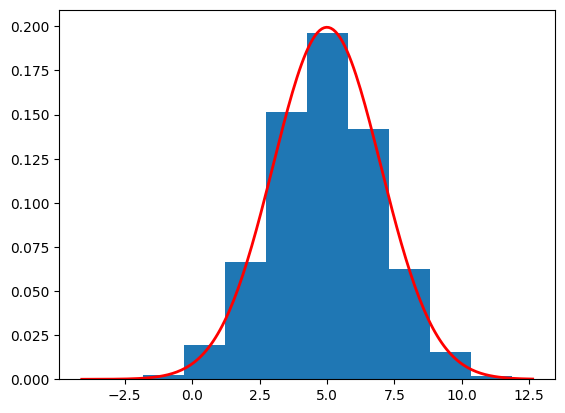

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt

class SDE_DIFF:
    def __init__(self, num_timesteps):
        self.num_timesteps = num_timesteps
        self.dt = 1/num_timesteps
        self.beta_bar = torch.linspace(0.0001, 0.02, num_timesteps) * num_timesteps # (beta_0,...,beta_{N-1})
        self.beta_dt = self.beta_bar * self.dt
        self.sqrt_beta_dt = torch.sqrt(self.beta_dt)

        self.ddpm_beta = torch.linspace(0.0001, 0.02, num_timesteps)
        self.alpha = torch.cumprod(1 - self.ddpm_beta, dim=0)
        self.sqrt_alpha = torch.sqrt(self.alpha)
    def forward_diff(self, x):
        B = x.shape[0]
        for t in range(self.num_timesteps):
            x = x - 0.5 * self.beta_dt[t] * x + self.sqrt_beta_dt[t] * torch.randn(B)
        return x
    def reverse_diff(self, num_samples):
        samples = torch.zeros((self.num_timesteps+1,num_samples))
        samples[self.num_timesteps] = torch.randn(num_samples)
        for t in range(self.num_timesteps-1,-1,-1):
            drift = 0.5 * samples[t+1] + self.score(samples[t+1],t+1)
            diff = self.sqrt_beta_dt[t] * torch.randn(num_samples)
            samples[t] = samples[t+1] + drift * self.beta_dt[t] + diff
        return samples
    def score(self,x,t):
        numerator = 5 *self.sqrt_alpha[t-1] - x
        denomenator = 3 * self.alpha[t-1] + 1
        return numerator / denomenator
    
sde_diff = SDE_DIFF(1000)
samples = sde_diff.reverse_diff(10000).numpy()

plot_sample = samples[0]

print(f"Estimated mean is {np.mean(plot_sample)}")
print(f"Estimated std is {np.std(plot_sample)}")
plt.hist(plot_sample, density=True)

# Define parameters for the normal distribution
mean = 5.0
std = 2.0

# Create a range of x values
xmin, xmax = plt.xlim()
x = torch.linspace(xmin, xmax, 200).numpy()

# Compute the normal PDF: (1/(σ√(2π))) exp(-(x-μ)²/(2σ²))
pdf = (1/(std * np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mean)/std)**2)

# Plot the PDF line
plt.plot(x, pdf, 'r', linewidth=2)

plt.show()


Now how do we use the DDPM formulation of diffusion with the exact score? We can derive the following relationship between the score and the error estimation that the neural network estimates:

$$\hat{\epsilon}(\boldsymbol{x}_{t+1}, t+1)=-\sqrt{1 - \bar{\alpha}_t}\nabla_{\boldsymbol{x}}\log p_{t+1}(\boldsymbol{x}_{t+1})$$

Estimated mean is 4.997849464416504
Estimated std is 1.9954274892807007


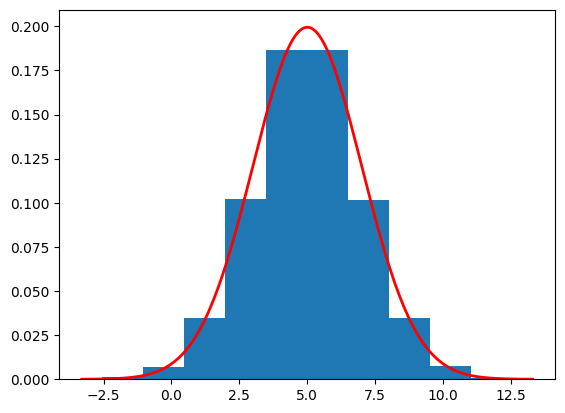

In [23]:
import torch

import numpy as np
import matplotlib.pyplot as plt
    
class Exact_DDPM():
    def __init__(self, num_timesteps):
        super(Exact_DDPM, self).__init__()
        self.num_timesteps = num_timesteps  
        self.beta = torch.linspace(0.0001, 0.02, num_timesteps)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha,dim=0)

        self.sqrt_beta = torch.sqrt(self.beta)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_alpha_bar = torch.sqrt(1-self.alpha_bar)
        self.reverse_factor = 1 / torch.sqrt(1-self.beta)
        self.reverse_factor_2 = torch.sqrt(1-self.alpha_bar)
    
    def reverse_diff(self, sample_size):
        with torch.inference_mode():
            samples = torch.zeros((self.num_timesteps+1, sample_size))
            samples[-1] = torch.randn(sample_size)
            for t in range(self.num_timesteps-1,-1,-1):
                # noise_hat =  - self.score(samples[t+1], t+1) * self.reverse_factor_2[t]
                # exact_sample = self.reverse_factor[t] * (samples[t+1] - self.beta[t] / self.reverse_factor_2[t] * noise_hat)
                # Note that this is equivalent to just:
                exact_sample = self.reverse_factor[t] * (samples[t+1] + self.beta[t]  * self.score(samples[t+1], t+1))
                if t != 0:
                    samples[t] = exact_sample + self.sqrt_beta[t] * torch.randn(sample_size)
                else:
                    samples[t] = exact_sample
            return samples
    
    def score(self,x,t):
        numerator = 5 *self.sqrt_alpha_bar[t-1] - x
        denomenator = 3 * self.alpha_bar[t-1] + 1
        return numerator / denomenator    
    


diffusion = Exact_DDPM(1000)

samples = diffusion.reverse_diff(10000).numpy()
plot_sample = samples[0]
print(f"Estimated mean is {np.mean(plot_sample)}")
print(f"Estimated std is {np.std(plot_sample)}")
plt.hist(plot_sample, density=True)

# Define parameters for the normal distribution
mean = 5.0
std = 2.0

# Create a range of x values
xmin, xmax = plt.xlim()
x = torch.linspace(xmin, xmax, 200).numpy()

# Compute the normal PDF: (1/(σ√(2π))) exp(-(x-μ)²/(2σ²))
pdf = (1/(std * np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mean)/std)**2)

# Plot the PDF line
plt.plot(x, pdf, 'r', linewidth=2)

plt.show()